In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

#### Code 3.1

$$Pr(vampire|positive) = \frac{Pr(positive|vampire) Pr(vampire)} {Pr(positive)}$$

$$Pr(positive) = Pr(positive|vampire) Pr(vampire) + Pr(positive|mortal) (1 − Pr(vampire))$$

In [3]:
PrPV = 0.95
PrPM = 0.01
PrV = 0.001
PrP = PrPV * PrV + PrPM * (1 - PrV)
PrVP = PrPV * PrV / PrP
PrVP

0.08683729433272395

#### Code 3.2 - 3.5

We are going to use the same function we use on chapter 2 (code 2.3)

In [4]:
def uniform_prior(grid_points):
    """
    Returns Uniform prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Uniform density of prior values
    """
    return np.repeat(5, grid_points)


def truncated_prior(grid_points, trunc_point=0.5):
    """
    Returns Truncated prior density

            Parameters:
                grid_points (numpy.array): Array of prior values
                trunc_point (double): Value where the prior is truncated

            Returns:
                density (numpy.array): Truncated density of prior values
    """
    return (np.linspace(0, 1, grid_points) >= trunc_point).astype(int)


def double_exp_prior(grid_points):
    """
    Returns Double Exponential prior density

            Parameters:
                grid_points (numpy.array): Array of prior values

            Returns:
                density (numpy.array): Double Exponential density of prior values
    """
    return np.exp(-5 * abs(np.linspace(0, 1, grid_points) - 0.5))

In [5]:
def binom_post_grid_approx(prior_func, grid_points=5, success=6, tosses=9):
    """
    Returns the grid approximation of posterior distribution with binomial likelihood.

            Parameters:
                    prior_func (function): A function that returns the likelihood of the prior
                    grid_points (int): Number of points in the prior grid
                    successes (int): Number of successes
                    tosses (int): number of tosses

            Returns:
                    p_grid (numpy.array): Array of prior values
                    posterior (numpy.array): Likelihood (density) of prior values
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = prior_func(grid_points)

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

In [6]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=6, tosses=9)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

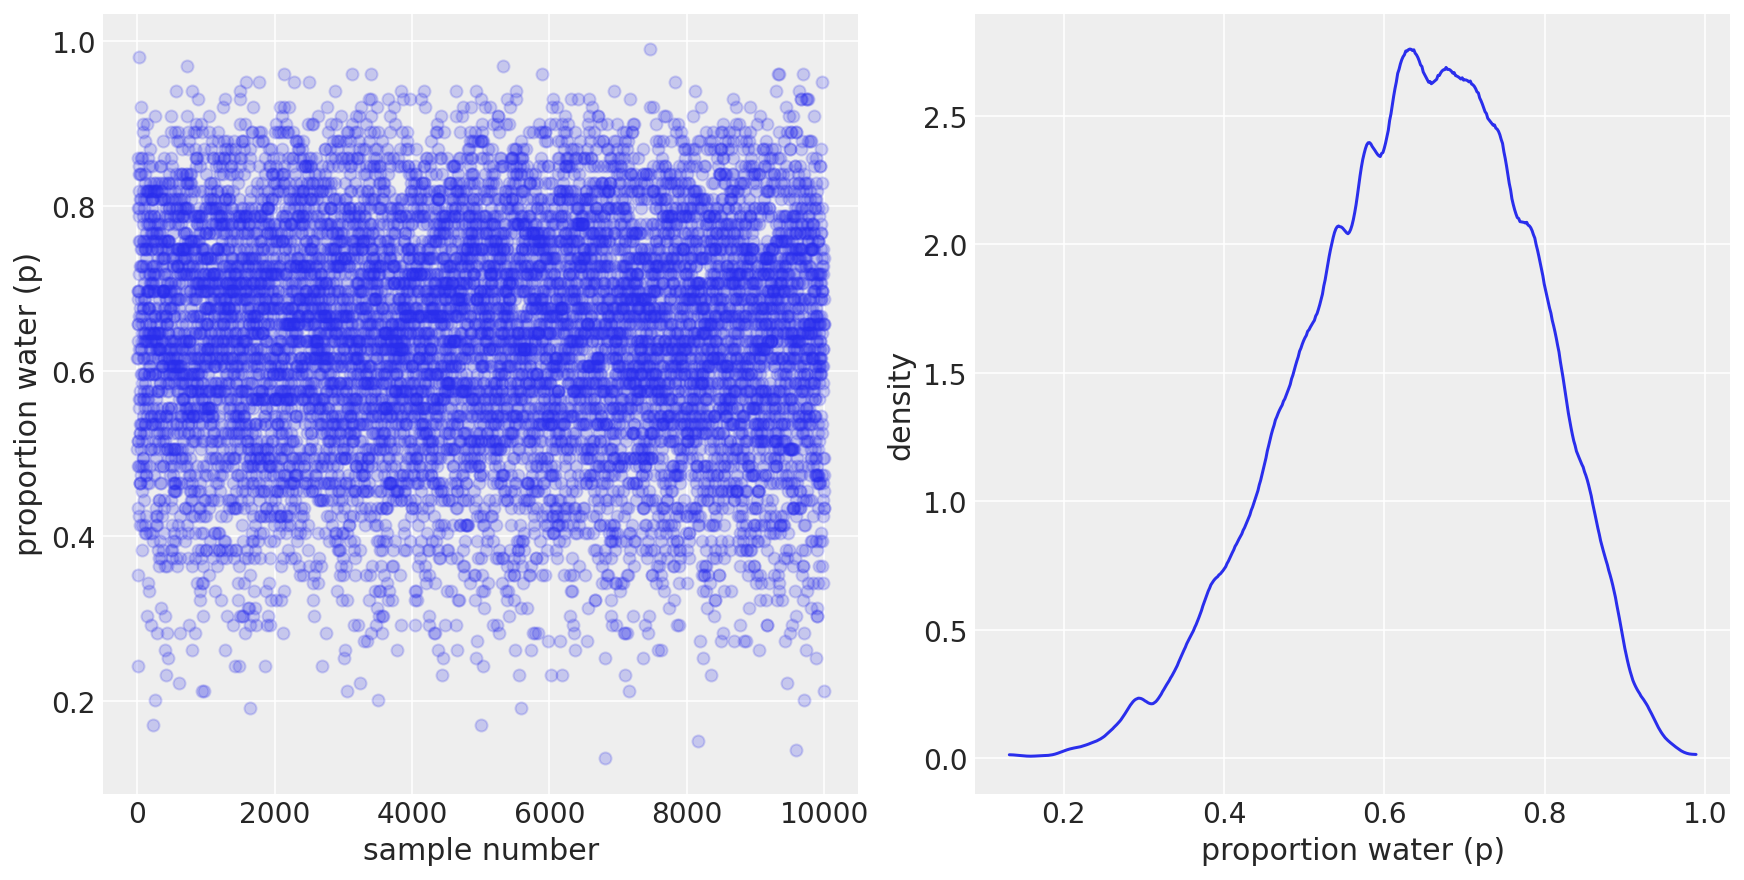

In [7]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax0.plot(samples, "o", alpha=0.2)
ax0.set_xlabel("sample number")
ax0.set_ylabel("proportion water (p)")
az.plot_kde(samples, ax=ax1)
ax1.set_xlabel("proportion water (p)")
ax1.set_ylabel("density");

#### Code 3.6

In [8]:
sum(posterior[p_grid < 0.5])

0.17183313110747475

#### Code 3.7

In [9]:
sum(samples < 0.5) / 1e4

0.1699

#### Code 3.8

In [10]:
sum((samples > 0.5) & (samples < 0.75)) / 1e4

0.6089

#### Code 3.9

In [11]:
np.percentile(samples, 80)

0.7676767676767677

#### Code 3.10

In [12]:
np.percentile(samples, [10, 90])

array([0.45454545, 0.81818182])

#### Code 3.11

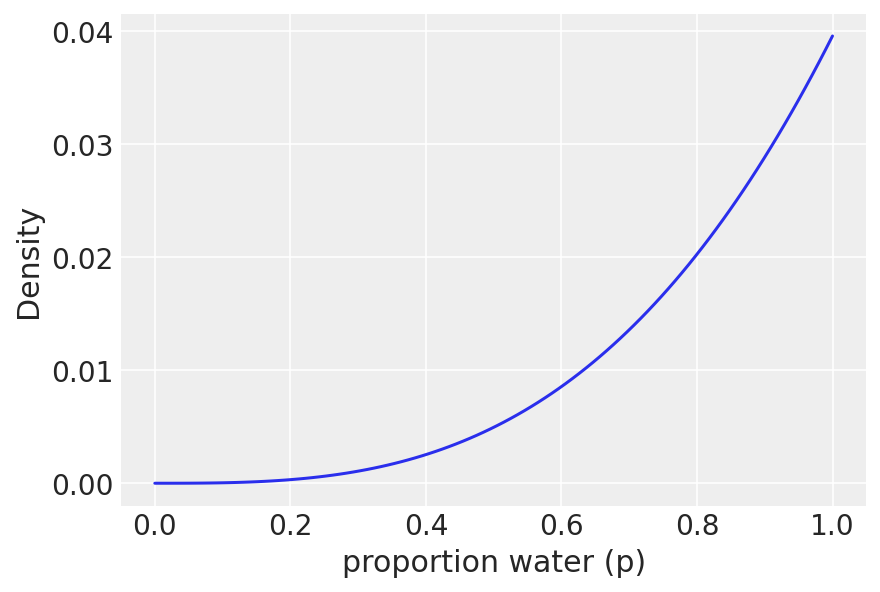

In [13]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=3, tosses=3)
plt.plot(p_grid, posterior)
plt.xlabel("proportion water (p)")
plt.ylabel("Density");

#### Code 3.12

In [14]:
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)
np.percentile(samples, [25, 75])

array([0.70707071, 0.93939394])

#### Code 3.13

In [30]:
az.hdi(samples, hdi_prob=0.5)

array([0.52525253, 0.71717172])

#### Code 3.14

In [16]:
p_grid[posterior == max(posterior)]

array([1.])

#### Code 3.15

In [17]:
stats.mode(samples)[0]

array([0.96969697])

#### Code 3.16

In [18]:
np.mean(samples), np.median(samples)

(0.8039616161616162, 0.8484848484848485)

#### Code 3.17

In [19]:
sum(posterior * abs(0.5 - p_grid))

0.31626874808692995

#### Code 3.18 and 3.19

In [20]:
loss = [sum(posterior * abs(p - p_grid)) for p in p_grid]
p_grid[loss == min(loss)]

array([0.84848485])

#### Code 3.20

In [21]:
stats.binom.pmf(range(3), n=2, p=0.7)

array([0.09, 0.42, 0.49])

#### Code 3.21

In [22]:
stats.binom.rvs(n=2, p=0.7, size=1)

array([1])

#### Code 3.22

In [23]:
stats.binom.rvs(n=2, p=0.7, size=10)

array([2, 2, 1, 1, 1, 2, 2, 0, 2, 1])

#### Code 3.23

In [24]:
dummy_w = stats.binom.rvs(n=2, p=0.7, size=int(1e5))
[(dummy_w == i).mean() for i in range(3)]

[0.09088, 0.42142, 0.4877]

#### Code 3.24, 3.25 and 3.26

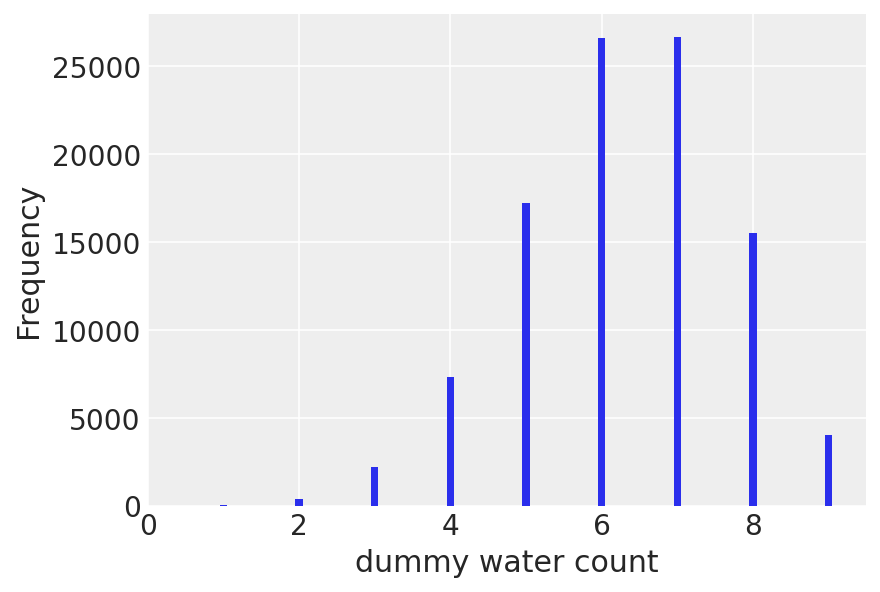

In [25]:
dummy_w = stats.binom.rvs(n=9, p=0.7, size=int(1e5))
# dummy_w = stats.binom.rvs(n=9, p=0.6, size=int(1e4))
# dummy_w = stats.binom.rvs(n=9, p=samples)
bar_width = 0.1
plt.hist(dummy_w, bins=np.arange(0, 11) - bar_width / 2, width=bar_width)
plt.xlim(0, 9.5)
plt.xlabel("dummy water count")
plt.ylabel("Frequency");

#### Code 3.27

In [26]:
p_grid, posterior = binom_post_grid_approx(uniform_prior, grid_points=100, success=6, tosses=9)
np.random.seed(100)
samples = np.random.choice(p_grid, p=posterior, size=int(1e4), replace=True)

#### Code 3.28

In [27]:
# fmt: off
birth1 = np.array([1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
                   1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1])
birth2 = np.array([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
                   1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1,
                   0, 0, 0, 1, 1, 1, 0, 0, 0, 0])
# fmt: on

#### Code 3.30

In [28]:
sum(birth1) + sum(birth2)

111

In [29]:
%watermark -n -u -v -iv -w

Last updated: Fri Jul 29 2022

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.4.0

arviz     : 0.12.1
matplotlib: 3.5.2
scipy     : 1.8.1
pymc      : 4.1.3
numpy     : 1.23.1

Watermark: 2.3.1

